#1.라이브러리 설치 및 불러오기

In [ ]:
!pip install barbar pytorch-ignite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 264 kB 5.1 MB/s 


In [ ]:
import torch
import os
import random
import torchvision
import pandas as pd
import torch.nn as nn
import numpy as np
from torchvision import transforms, datasets
from shutil import copyfile, move
from torch.utils.tensorboard import SummaryWriter
from barbar import Bar
from torchsummary import summary
from ignite.metrics import Accuracy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
random.seed(42)

#2.데이터 준비

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=50, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when monitored metric decrease.'''
        if self.verbose:
            self.trace_func(f'Monitored metric has improved ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), f'/content/drive/MyDrive/Colab Notebooks/Section6_CP2_project/ham10000_dataset/skin_models_not_segmented/skinmodel50.pt') 
        self.val_loss_min = val_loss

In [ ]:
def split_data(source, train, validation, test, train_split_size):    
    files = []
    for filename in os.listdir(source):
        file = source + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    train_length = int(len(files) * train_split_size)
    validation_length = int((len(files) - train_length) / 2)
    test_length = len(files) - train_length - validation_length

    shuffled_set = random.sample(files, len(files))
    train_set = shuffled_set[0:train_length]
    validation_set = shuffled_set[train_length:train_length + validation_length]
    test_set = shuffled_set[train_length + validation_length:]


    for filename in train_set:
        this_file = source + filename
        destination = train + filename
        copyfile(this_file, destination)

    for filename in validation_set:
        this_file = source + filename
        destination = validation + filename
        copyfile(this_file, destination)

    for filename in test_set:
        this_file = source + filename
        destination = test + filename
        copyfile(this_file, destination)

In [ ]:
# source_MEL = '/content/drive/MyDrive/Colab Notebooks/new_data_v3/images/MEL/'
# source_NV = '/content/drive/MyDrive/Colab Notebooks/new_data_v3/images/NV/'
# source_SC = '/content/drive/MyDrive/Colab Notebooks/new_data_v3/images/Other_SC/'




train_MEL = '/content/drive/MyDrive/Colab Notebooks/Section6_CP2_project/ham10000_dataset/new_data_v2/new_data_v2_images/train/MEL/'
train_NV = '/content/drive/MyDrive/Colab Notebooks/Section6_CP2_project/ham10000_dataset/new_data_v2/new_data_v2_images/train/NV/'
train_SC = '/content/drive/MyDrive/Colab Notebooks/Section6_CP2_project/ham10000_dataset/new_data_v2/new_data_v2_images/train/Other_SC/'

valid_MEL = '/content/drive/MyDrive/Colab Notebooks/Section6_CP2_project/ham10000_dataset/new_data_v2/new_data_v2_images/validation/MEL/'
valid_NV = '/content/drive/MyDrive/Colab Notebooks/Section6_CP2_project/ham10000_dataset/new_data_v2/new_data_v2_images/validation/NV/'
valid_SC = '/content/drive/MyDrive/Colab Notebooks/Section6_CP2_project/ham10000_dataset/new_data_v2/new_data_v2_images/validation/Other_SC/'

test_MEL = '/content/drive/MyDrive/Colab Notebooks/Section6_CP2_project/ham10000_dataset/new_data_v2/new_data_v2_images/test/MEL/'
test_NV = '/content/drive/MyDrive/Colab Notebooks/Section6_CP2_project/ham10000_dataset/new_data_v2/new_data_v2_images/test/NV/'
test_SC = '/content/drive/MyDrive/Colab Notebooks/Section6_CP2_project/ham10000_dataset/new_data_v2/new_data_v2_images/test/Other_SC/'

In [ ]:
# 라벨 별 폴더에 저장된 image들을 train, validation, test폴더에 가고자 하는 데이터들로 분할 한 뒤 복사 붙혀넣기 하는 코드

# split_data(source_MEL, train_MEL, valid_MEL, test_MEL, 0.8)
# split_data(source_NV, train_NV, valid_NV, test_NV, 0.8)
# split_data(source_SC, train_SC, valid_SC, test_SC, 0.8)

In [ ]:
print('-------------MEL-------------')
print('train 셋:', len(os.listdir(train_MEL)))
print('validation 셋:', len(os.listdir(valid_MEL)))
print('test 셋:', len(os.listdir(test_MEL)))

print('-------------NV-------------')
print('train 셋:', len(os.listdir(train_NV)))
print('validation 셋:', len(os.listdir(valid_NV)))
print('test 셋:', len(os.listdir(test_NV)))

print('-------------Other_SC-------------')
print('train 셋:', len(os.listdir(train_SC)))
print('validation 셋:', len(os.listdir(valid_SC)))
print('test 셋:', len(os.listdir(test_SC)))

-------------MEL-------------
train 셋: 1002
validation 셋: 60
test 셋: 51
-------------NV-------------
train 셋: 1002
validation 셋: 324
test 셋: 273
-------------Other_SC-------------
train 셋: 1002
validation 셋: 117
test 셋: 77


In [ ]:
train_dir = r'/content/drive/MyDrive/Colab Notebooks/Section6_CP2_project/ham10000_dataset/new_data_v2/new_data_v2_images/train/'
valid_dir = r'/content/drive/MyDrive/Colab Notebooks/Section6_CP2_project/ham10000_dataset/new_data_v2/new_data_v2_images/validation/'
test_dir = r'/content/drive/MyDrive/Colab Notebooks/Section6_CP2_project/ham10000_dataset/new_data_v2/new_data_v2_images/test/'

#3.데이터 증강

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 280)),
    transforms.CenterCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply(transforms=[transforms.RandomRotation(degrees=(-180, 180))], p=0.99),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

valid_transforms = transforms.Compose([
    transforms.Resize((224, 280)),
    torchvision.transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

test_transforms = transforms.Compose([
    transforms.Resize((224, 280)),
    torchvision.transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_dataset = datasets.ImageFolder(
    train_dir, transform=train_transforms)

valid_dataset = datasets.ImageFolder(
    valid_dir, transform=valid_transforms)

test_dataset = datasets.ImageFolder(
    test_dir, transform=test_transforms)

In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True,
    pin_memory=False, drop_last=False)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=64, shuffle=True,
    pin_memory=False, drop_last=False)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=64, shuffle=True,
    pin_memory=False, drop_last=False)

#4.모델학습

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = torchvision.models.resnet50(pretrained=True).to(device)

model.fc = nn.Linear(2048, 3).to(device)

# model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/new_data_v3/skin_models_not_segmented/skinmodel50.pt')) 

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.0001)

epochs = 999

writer = SummaryWriter(log_dir='/content/drive/MyDrive/Colab Notebooks/Section6_CP2_project/ham10000_dataset/skin_logs', filename_suffix="skin50")

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Shows info about model
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
early_stopping = EarlyStopping(patience=50, verbose=True)

for epoch in range(epochs):
    train_loss = 0.00
    valid_loss = 0.00
    train_accuracy = Accuracy()
    valid_accuracy = Accuracy()
    print(f'Epoch {epoch+1}')

    # Training loop
    for idx, (inputs, labels) in enumerate(Bar(train_loader)):
        model.train()
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() 
        outputs = model(inputs) 
        loss = criterion(outputs, labels)
        loss.backward() 
        optimizer.step() 
        train_loss += loss.item()
        train_accuracy.update((nn.functional.softmax(outputs, dim=1), labels))
    print(f"Train Accuracy: {train_accuracy.compute()}")
    train_loss /= len(train_loader)
    train_loss_formated = "{:.4f}".format(train_loss)

    # Validation loop
    with torch.no_grad():
        for inputs, labels in valid_loader:
            model.eval()           
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            valid_accuracy.update((nn.functional.softmax(outputs, dim=1), labels))
    print(f"Val Accuracy: {valid_accuracy.compute()}")
    valid_loss /= len(valid_loader)
    valid_loss_formated = "{:.4f}".format(valid_loss)
    print(f'Training Loss: {train_loss_formated}')
    print(f"Validation Loss: {valid_loss_formated}")

    # TensorBoard writer 
    writer.add_scalar('Loss/train', train_loss, epoch+1)
    writer.add_scalar('Loss/val', valid_loss, epoch+1)
    writer.add_scalar('Accuracy/train', train_accuracy.compute(), epoch+1)
    writer.add_scalar('Accuracy/val', valid_accuracy.compute(), epoch+1)

    # Early Stopping
    early_stopping(valid_loss, model)       
    if early_stopping.early_stop:
        print("Early stopping")
        break
        
   

Epoch 1
3006/3006: [===============================>] - ETA 1.4s
Train Accuracy: 0.5658682634730539
Val Accuracy: 0.656686626746507
Training Loss: 0.9183
Validation Loss: 0.7576
Monitored metric has improved (inf --> 0.757579).  Saving model ...
Epoch 2
3006/3006: [===============================>] - ETA 0.9s
Train Accuracy: 0.7139055222887558
Val Accuracy: 0.7724550898203593
Training Loss: 0.6630
Validation Loss: 0.5441
Monitored metric has improved (0.757579 --> 0.544117).  Saving model ...
Epoch 3
3006/3006: [===============================>] - ETA 1.0s
Train Accuracy: 0.7518296739853626
Val Accuracy: 0.7864271457085829
Training Loss: 0.5794
Validation Loss: 0.5035
Monitored metric has improved (0.544117 --> 0.503466).  Saving model ...
Epoch 4
3006/3006: [===============================>] - ETA 1.0s
Train Accuracy: 0.7817697937458417
Val Accuracy: 0.7684630738522954
Training Loss: 0.5216
Validation Loss: 0.5693
EarlyStopping counter: 1 out of 50
Epoch 5
3006/3006: [================

KeyboardInterrupt: ignored

In [ ]:
# load the last checkpoint with the best model

model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Section6_CP2_project/ham10000_dataset/skin_models_not_segmented/skinmodel50.pt')) 
# model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/new_data_v3/skin_models_not_segmented/skinmodel50.pt', map_location=torch.device('cpu')))  #cpu

<All keys matched successfully>

In [ ]:
class_names = train_dataset.classes
print('클래스:', class_names)

클래스: ['MEL', 'NV', 'Other_SC']


In [ ]:
import time
import matplotlib.pyplot as plt

def imshow(input, title):
    # torch.Tensor를 numpy 객체로 변환
    input = input.numpy().transpose((1, 2, 0))
    # 이미지 정규화 해제하기
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # 이미지 출력
    plt.figure(figsize=(10, 10))
    plt.imshow(input)
    plt.title(title)
    plt.show()

[예측 결과: Other_SC] (실제 정답: Other_SC)


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52769 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44208 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44284 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 52769 missing from current font.
  font.set_te

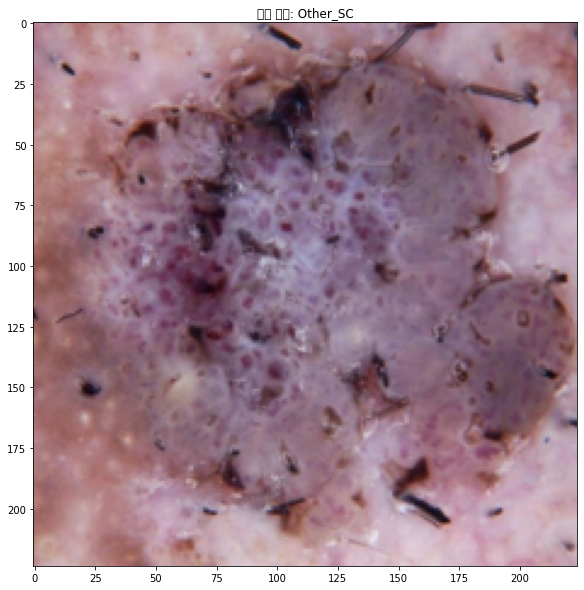

[예측 결과: NV] (실제 정답: NV)


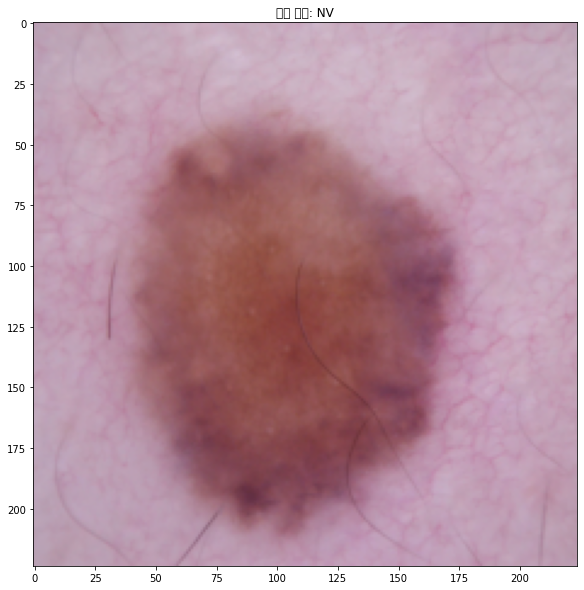

[예측 결과: NV] (실제 정답: NV)


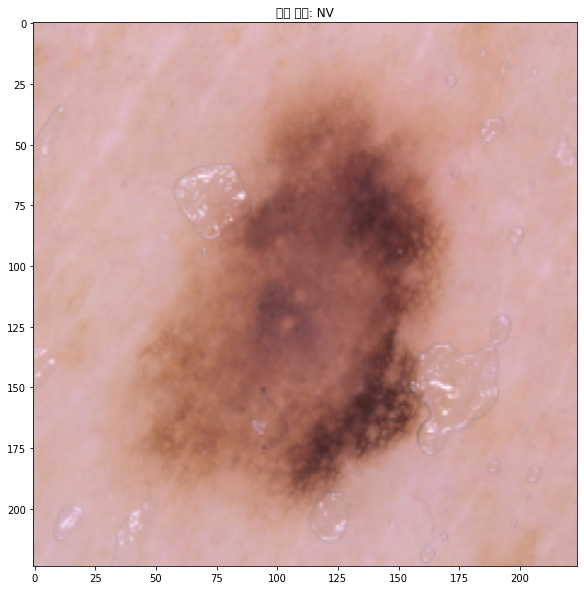

[예측 결과: NV] (실제 정답: NV)


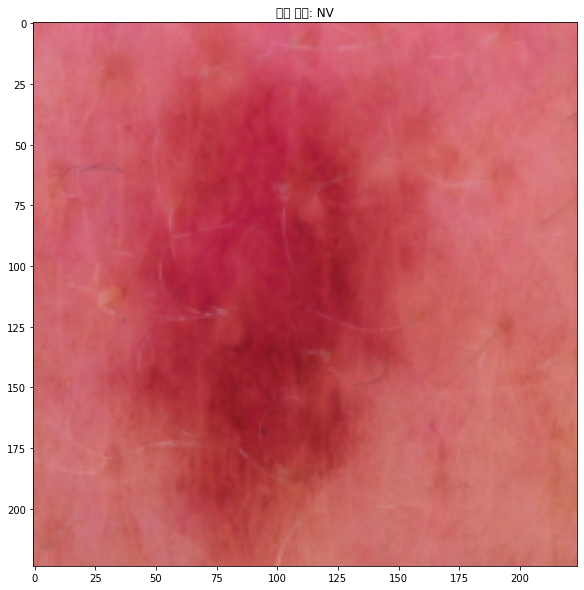

[예측 결과: NV] (실제 정답: NV)


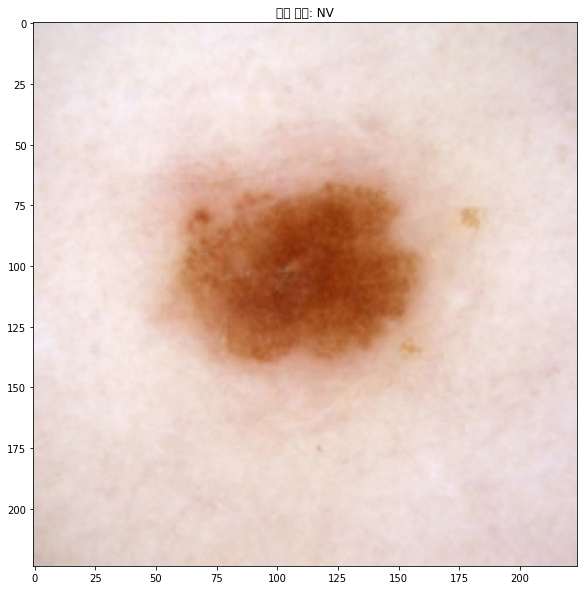

[예측 결과: Other_SC] (실제 정답: Other_SC)


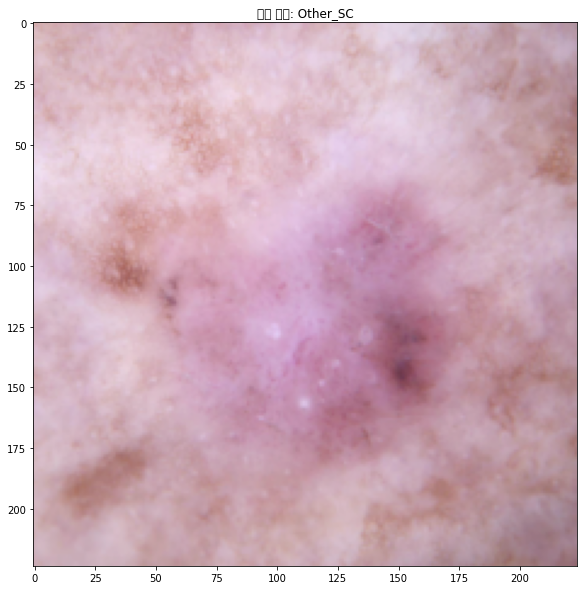

[예측 결과: NV] (실제 정답: NV)


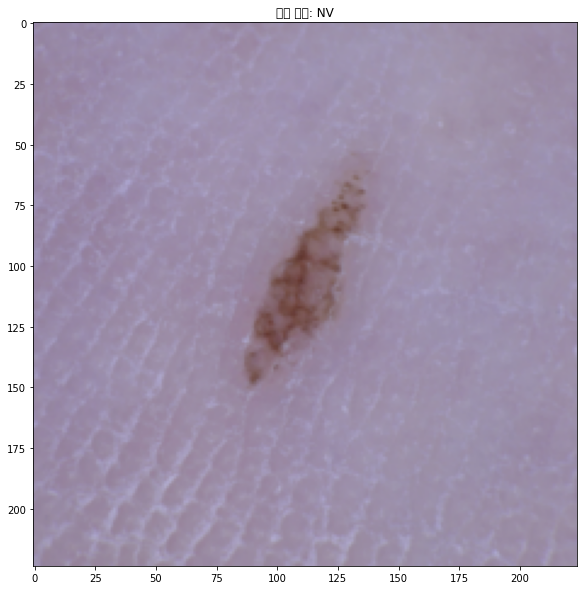

[Test Phase] Loss: 0.4387 Acc: 85.0374% Time: 8.1759s


In [ ]:
y_pred = []
y_true = []

model.eval()
start_time = time.time()
with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
        print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
        imshow(inputs.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])
        y_pred += preds.tolist()
        y_true += labels.data.tolist()


    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects / len(test_dataset) * 100.
    print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

#5.결과출력

In [ ]:
# num_classes = 3

# predlist = torch.zeros(0,dtype=torch.long, device='cpu')
# lbllist = torch.zeros(0,dtype=torch.long, device='cpu')
# predlistauc = torch.zeros(0,dtype=torch.long, device='cpu')
# with torch.no_grad():
#     for i, (inputs, classes) in enumerate(test_loader):
#         model.eval()
#         inputs = inputs.to(device)
#         classes = classes.to(device)
#         outputs = model(inputs)
#         _, preds = torch.max(outputs, 1)

#         # Append batch prediction results
#         predlist=torch.cat([predlist,preds.view(-1).cpu()])
#         lbllist=torch.cat([lbllist,classes.view(-1).cpu()])
#         predlistauc = torch.cat([predlistauc,nn.functional.softmax(outputs, dim=1).cpu()])
# predlist = predlist.numpy()
# lbllist = lbllist.numpy()
# predlistauc = predlistauc.numpy()

# # Confusion matrix, classification report and AUC
# conf_mat=confusion_matrix(lbllist, predlist)
# target_names = class_names
# ConfusionMatrixDisplay(conf_mat, display_labels=target_names).plot(values_format="d")
# print(classification_report(lbllist, predlist, target_names=target_names))
# lbllist_one_hot = nn.functional.one_hot(torch.tensor([lbllist]), num_classes=num_classes)
# every_auc = roc_auc_score(lbllist_one_hot.view([predlistauc.shape[0], predlistauc.shape[1]]), 
#                                           predlistauc, multi_class='ovr', average=None)
# for i, every in enumerate(target_names):
#     print(f'AUC of class {every} = {every_auc[i]}')

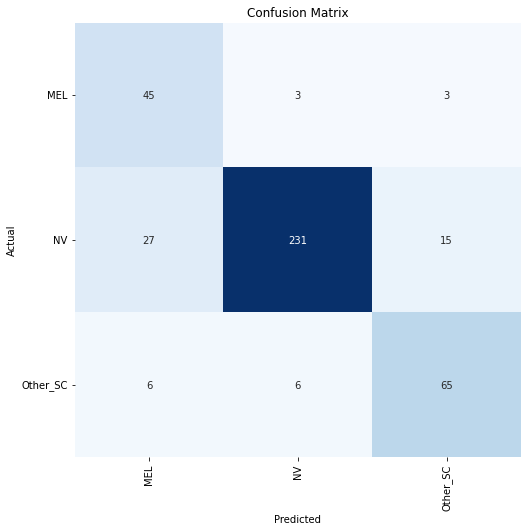

In [ ]:
# confusion matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)        
length=len(class_names)
if length < 8:
  fig_width = 8
  fig_height = 8
else:
  fig_width= int(length * .5)
  fig_height= int(length * .5)

plt.figure(figsize=(fig_width, fig_height))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
plt.xticks(np.arange(length)+.5, class_names, rotation= 90)
plt.yticks(np.arange(length)+.5, class_names, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
clr = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

         MEL       0.58      0.88      0.70        51
          NV       0.96      0.85      0.90       273
    Other_SC       0.78      0.84      0.81        77

    accuracy                           0.85       401
   macro avg       0.77      0.86      0.80       401
weighted avg       0.88      0.85      0.86       401

